# Quick peak fitting while on Raman
- This folder is for quick peak fitting while on the Raman 
- It doesnt require you to run the Ne line file - it just uses a guess of the average Ne line of your system
- This is very useful when looking at new samples so you know what sort of densities you are working with, so can adjust laser power etc. 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import joblib
import DiadFit as pf
pf.__version__

'1.0.0'

## Specifying filetype and folder

In [2]:
import os
DayFolder=os.getcwd()
meta_path=DayFolder 
spectra_path=DayFolder + '\spectra'
# Filetype and extension for spectra
spectra_filetype='headless_txt'
spectra_file_ext='.txt'
# file extension for spectra
meta_file_ext='.txt'
# Does your file start with a prefix? E.g 01 Ne_line.txt?
prefix=False
# If so - what is the character separating the prefix from the real name
prefix_str=' '
# Does your instrument have TruPower (WITEC)
TruPower=False
# Save settings to a file to use in all other notebooks
pf.save_settings(meta_path, spectra_path, spectra_filetype, prefix, prefix_str, spectra_file_ext, meta_file_ext, TruPower)



Good job! Filetype headless_txt is valid.


## Grab all files

In [3]:
exclude_str=['Ne', 'NE', 'Si', 'nodiad', 'Spectrum', 'CRR', 'no_diad', 'settings']
Diad_Files=pf.get_files(path=spectra_path, file_ext=spectra_file_ext, exclude_str=exclude_str)
print(Diad_Files)

['02 MLP_202_MIA_Rep1.txt', '03 MLP_202_MIA_Rep2.txt', '04 MLP_202_MIA_Rep3.txt', '06 MLP_203_MIC_Rep1.txt', '07 MLP_203_MIC_Rep2.txt', '08 MLP_203_MIC_Rep3.txt', '10 ML22_77_1_MIA_Rep1.txt', '11 ML22_77_1_MIA_Rep2.txt', '12 ML22_77_1_MIA_Rep3.txt', '14 ML22_77_1_MIB_Rep1.txt', '15 ML22_77_1_MIB_Rep2.txt', '16 ML22_77_1_MIB_Rep3.txt']


### Lets plot the diad to have a look at it

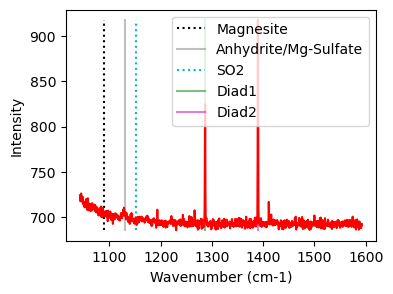

In [4]:
i=0
plot1=pf.plot_diad(path=spectra_path, filename=Diad_Files[i], filetype=spectra_filetype)

## Get approximate peak positoins

In [5]:


diad_id_config=pf.diad_id_config(prominence=12, width=1)
diad_id_config

fit_params, data_y_all=pf.loop_approx_diad_fits(spectra_path=spectra_path, config=diad_id_config, 
                       Diad_Files=Diad_Files, filetype=spectra_filetype, plot_figure=False)
fit_params.head()

100%|██████████| 12/12 [00:06<00:00,  1.75it/s]


,filename,approx_split,Diad1_pos,Diad2_pos,HB1_pos,HB2_pos,C13_pos,Diad1_abs_prom,Diad2_abs_prom,HB1_abs_prom,...,HB2_height,C13_height,Diad1_height,HB1_height,Diad1_Median_Bck,Diad2_Median_Bck,C13_HB2_abs_prom_ratio,Diad2_HB2_Valley_prom,HB1_prom/std_betweendiads,HB2_prom/std_betweendiads
0,02 MLP_202_MIA_Rep1.txt,103.018815,1286.624244,1389.643060,1266.143673,1410.860580,NaN,134.036701,225.401576,13.532328,...,716.992733,NaN,827.370044,707.532328,693.333343,692.583343,NaN,0.997586,6.212120,11.243579
1,03 MLP_202_MIA_Rep2.txt,102.985818,1286.651743,1389.637560,1266.160172,1410.822083,NaN,140.444843,221.279869,14.352585,...,707.020542,NaN,828.778156,703.685898,688.333313,687.000000,NaN,0.996107,6.243671,8.854348
2,04 MLP_202_MIA_Rep3.txt,102.991317,1286.640743,1389.632061,1266.083177,1410.816583,NaN,121.100359,203.619159,9.337215,...,705.676818,NaN,808.100359,697.003902,687.000000,685.499985,NaN,0.991736,3.154570,7.098264
3,06 MLP_203_MIC_Rep1.txt,102.969319,1286.745236,1389.714555,NaN,1410.959573,NaN,69.074486,95.597439,NaN,...,744.561478,NaN,796.741143,NaN,727.666657,724.916672,NaN,0.990555,NaN,6.943506
4,07 MLP_203_MIC_Rep2.txt,102.952820,1286.723238,1389.676058,1266.396655,1410.926576,NaN,82.249643,129.069670,6.465334,...,747.056888,NaN,810.749643,735.798647,728.500000,725.500000,NaN,0.989386,1.890395,6.936522


## Fit Diad 1
- Tweak the parameters in the config files for each group. E.g. how many peaks (fit_peaks), the background positions, the sigma of the diad, and whether or not you want a gaussian background

In [6]:
model_name='PseudoVoigtModel'
diad1_fit_config_init=pf.diad1_fit_config(
model_name=model_name, fit_peaks=2,
N_poly_bck_diad1=2, lower_bck_diad1=(1180, 1240),
upper_bck_diad1=(1315, 1350),
diad_sigma=0.6,
x_range_residual=10, x_range_baseline=30, 
    y_range_baseline=100, 
HB_prom=fit_params['HB1_abs_prom'].iloc[i], 
diad_prom=fit_params['Diad1_abs_prom'].iloc[i])
diad1_fit_config_init


diad1_fit_config(model_name='PseudoVoigtModel', fit_peaks=2, N_poly_bck_diad1=2, lower_bck_diad1=(1180, 1240), upper_bck_diad1=(1315, 1350), fit_gauss=False, gauss_amp=1000, diad_sigma=0.6, diad_sigma_min_allowance=0.2, diad_sigma_max_allowance=5, diad_prom=134.03670069283817, HB_prom=13.532327757567145, x_range_baseline=30, y_range_baseline=100, dpi=200, x_range_residual=10, return_other_params=False)

### See what these fit parameters look like for diad1

,Diad1_Combofit_Cent,Diad1_Voigt_Cent,Diad1_cent_err,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Voigt_Gamma,HB1_Cent,HB1_Area,HB1_Sigma,Diad1_Combofit_Height,Diad1_Residual,Diad1_Prop_Lor,Diad1_fwhm,Diad1_refit,Diad1_Asym50,Diad1_Asym70,Diad1_Yuan2017_sym_factor,Diad1_Remigi2021_BSF,Diad1_PDF_Model
0,1286.567854,1286.567904,0.011029,157.944343,0.476459,0,1266.259114,18.480157,0.317196,140.79906,2.256449,0.29717,0.952918,Flagged Warnings:,1.215328,1.24507,0.20519,0.006768,PseudoVoigtModel


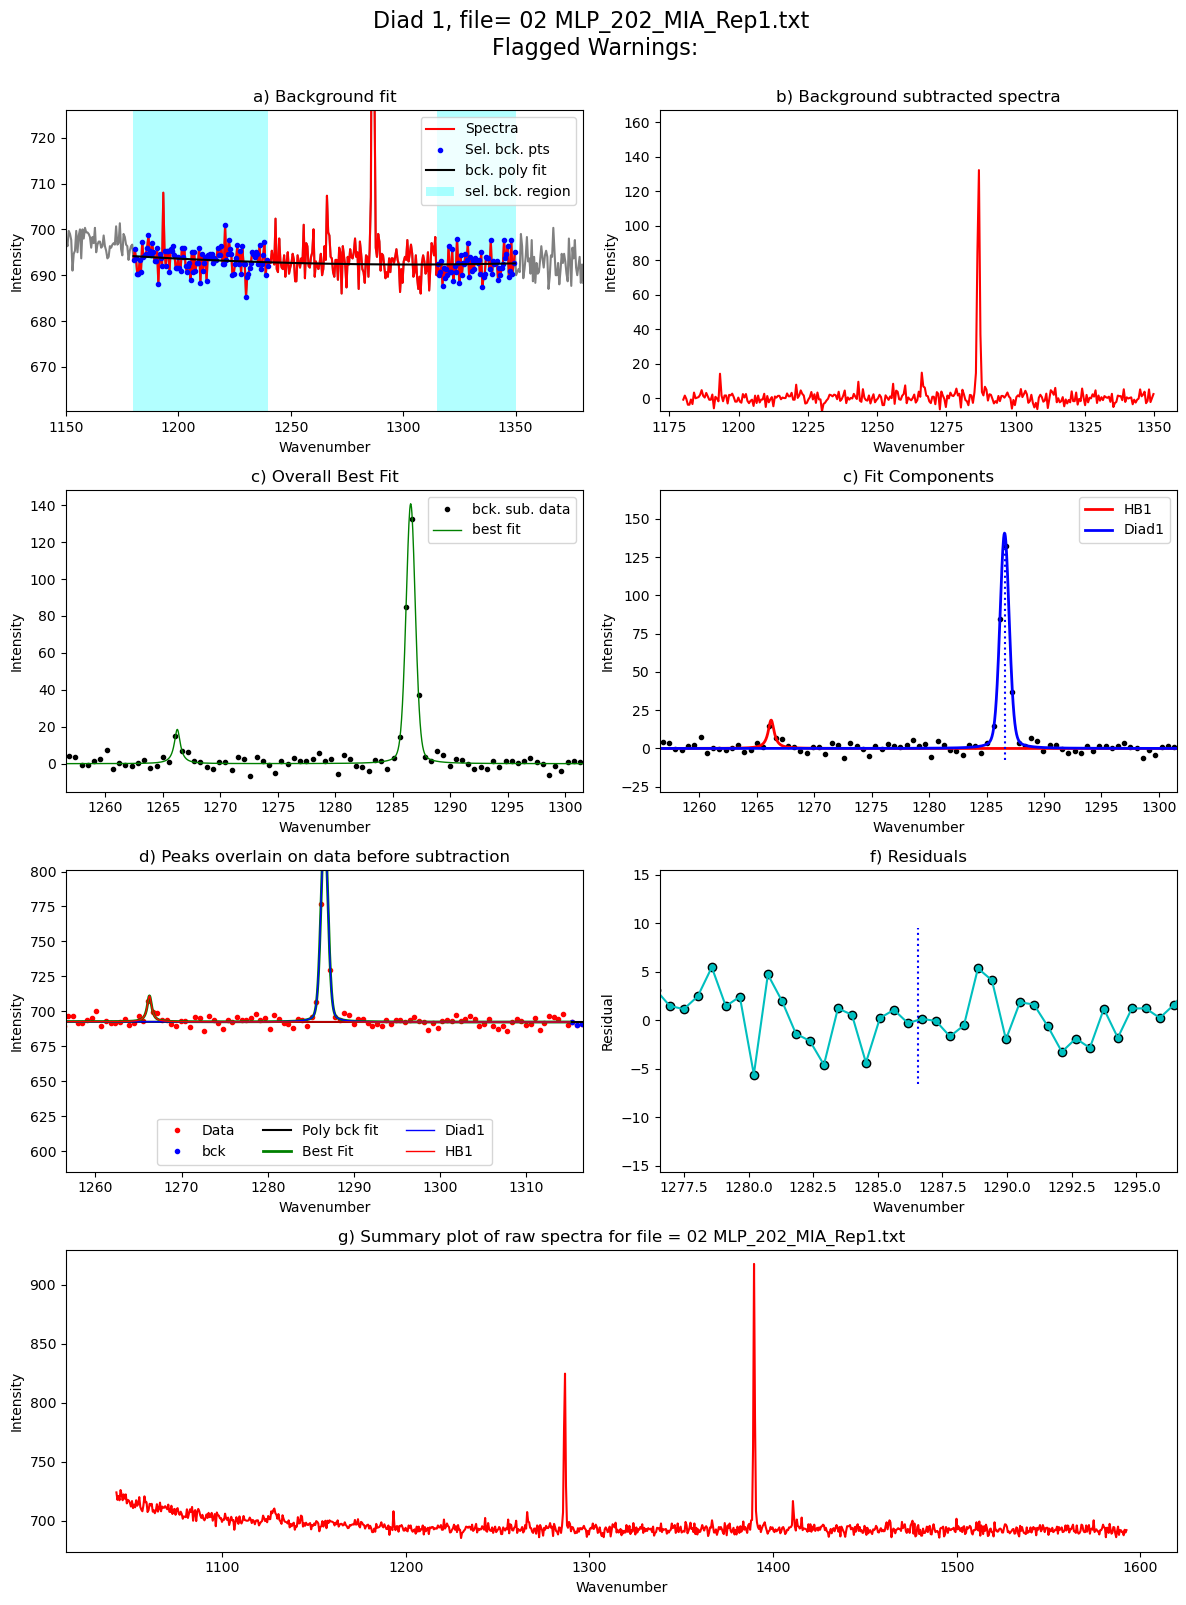

In [7]:
Diad1_fit=pf.fit_diad_1_w_bck(config1=diad1_fit_config_init,
config2=diad_id_config,
path=spectra_path, filename=Diad_Files[i],
filetype=spectra_filetype, plot_figure=True, close_figure=False,
Diad_pos=fit_params['Diad1_pos'].iloc[i],
HB_pos=fit_params['HB1_pos'].iloc[i])
Diad1_fit

In [8]:
diad1_fit_config2=diad1_fit_config_init

## Fit diad2

In [9]:

diad2_fit_config_init=pf.diad2_fit_config(model_name=model_name,
fit_peaks=3, fit_gauss=True, gauss_amp= 2*fit_params['HB2_abs_prom'].iloc[i],
lower_bck_diad2=(1310, 1350), diad_sigma=1,  N_poly_bck_diad2=2,                                       
x_range_residual=30, y_range_baseline=100,  
x_range_baseline=30,
HB_prom=fit_params['HB2_abs_prom'].iloc[i], 
diad_prom=fit_params['Diad2_abs_prom'].iloc[i],
C13_prom=fit_params['C13_abs_prom'].iloc[i])
diad2_fit_config_init



diad2_fit_config(model_name='PseudoVoigtModel', fit_peaks=3, N_poly_bck_diad2=2, lower_bck_diad2=(1310, 1350), upper_bck_diad2=(1440, 1470), fit_gauss=True, gauss_amp=48.98546686812665, diad_sigma=1, diad_sigma_min_allowance=0.2, diad_sigma_max_allowance=5, diad_prom=225.40157607002618, HB_prom=24.492733434063325, C13_prom=nan, x_range_baseline=30, y_range_baseline=100, plot_figure=True, dpi=200, x_range_residual=30, return_other_params=False)

### See what these fit parameters look like for diad2

,Diad2_Combofit_Cent,Diad2_Voigt_Cent,Diad2_cent_err,Diad2_Voigt_Area,Diad2_Voigt_Sigma,Diad2_Voigt_Gamma,HB2_Cent,HB2_Area,HB2_Sigma,Diad2_Combofit_Height,...,Diad2_fwhm,Diad2_Gauss_Cent,Diad2_Gauss_Area,Diad2_Gauss_Sigma,Diad2_refit,Diad2_Asym50,Diad2_Asym70,Diad2_Yuan2017_sym_factor,Diad2_Remigi2021_BSF,Diad2_PDF_Model
0,1389.668277,1389.668227,0.006975,234.601786,0.428936,0,1410.979249,26.030601,0.26535,226.431475,...,0.857872,1391.300959,0.489863,4.288096,Flagged Warnings:,1.071713,1.112121,0.061521,0.003789,PseudoVoigtModel


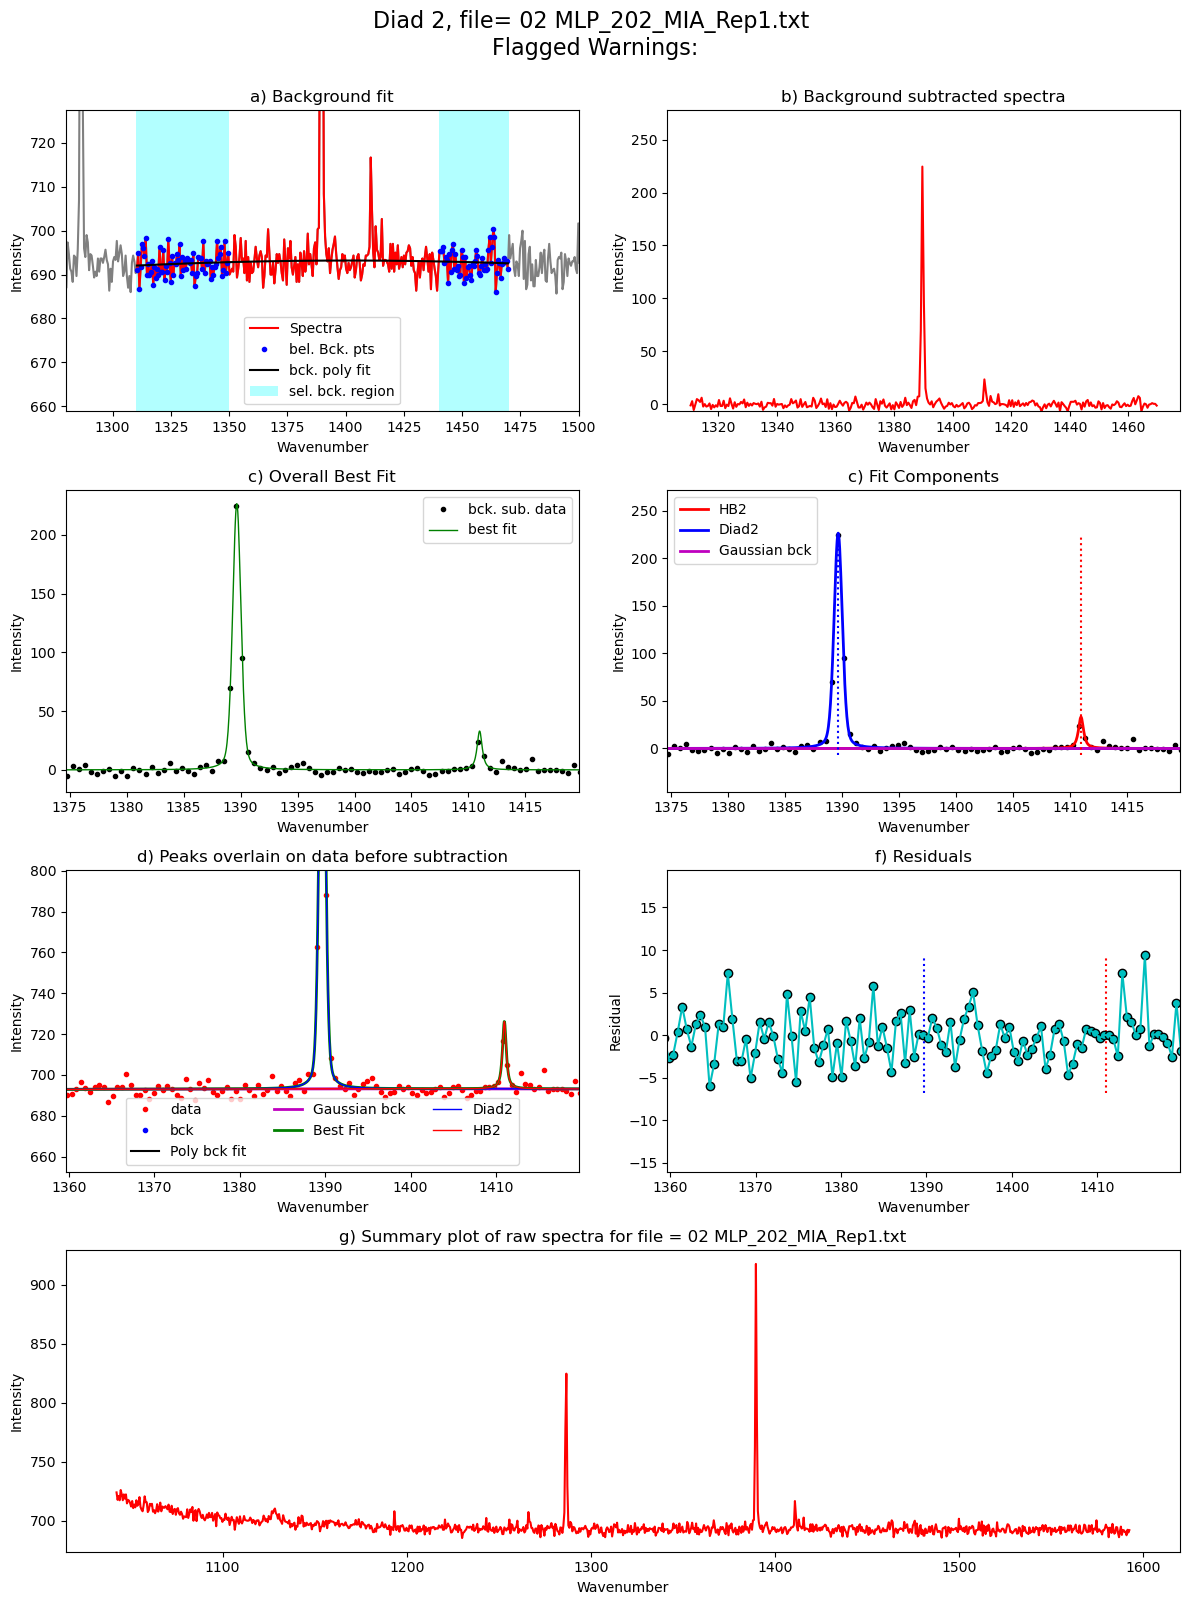

In [10]:
Diad2_fit=pf.fit_diad_2_w_bck(config1=diad2_fit_config_init,
    config2=diad_id_config,
path=spectra_path, filename=Diad_Files[i], filetype=spectra_filetype,
plot_figure=True, close_figure=False, 
Diad_pos=fit_params['Diad2_pos'].iloc[i],
HB_pos=fit_params['HB2_pos'].iloc[i], 
C13_pos=fit_params['C13_pos'].iloc[i])
Diad2_fit.to_clipboard(excel=True)
Diad2_fit

## Loop over all the files in the group
- This will loop over all the 

In [11]:
diad2_fit_config_init
from tqdm import tqdm
plot_figure=False# If False, Means doesnt have to make figures, lot faster. 
close_figure=False # If True, wont show figures in notebook, but will still save them in a folder 
Diad_Files_i=Diad_Files
df_Merge = pd.DataFrame([])
for i in tqdm(range(0, len(Diad_Files))): #
    tqdm.write(f"Processing file: {Diad_Files[i]}")
    
    
    # For diad1, config file like you had in the previous. 
    # Only really used to exclude a range (say your spectra has a known spec)
    diad_id_config=pf.diad_id_config(exclude_range1=[1308, 1309])
    
    # Here, the prominence are taken from the fitting in the last notebook
    diad1_fit_config2.HB_prom=fit_params['HB1_abs_prom'].iloc[i]
    diad1_fit_config2.diad_prom=fit_params['Diad1_abs_prom'].iloc[i]
    diad1_fit_config2.gauss_amp=2*fit_params['HB1_abs_prom'].iloc[i]

    Diad1_fit=pf.fit_diad_1_w_bck(config1=diad1_fit_config2,
    config2=diad_id_config, path=spectra_path, filename=fit_params['filename'].iloc[i],
    filetype=spectra_filetype, plot_figure=plot_figure, close_figure=close_figure,
    Diad_pos=fit_params['Diad1_pos'].iloc[i],
    HB_pos=fit_params['HB1_pos'].iloc[i])

    ## Same for diad2, just also has a C13 peak
    diad2_fit_config_init.HB_prom=fit_params['HB2_abs_prom'].iloc[i]
    diad2_fit_config_init.diad_prom=fit_params['Diad2_abs_prom'].iloc[i]
    diad2_fit_config_init.gauss_amp= 2*fit_params['HB2_abs_prom'].iloc[i]
    diad2_fit_config_init.C13_prom=fit_params['C13_abs_prom'].iloc[i]
    
    
    Diad2_fit=pf.fit_diad_2_w_bck(config1=diad2_fit_config_init,
        config2=diad_id_config,
    path=spectra_path, filename=fit_params['filename'].iloc[i], 
    filetype=spectra_filetype,
    plot_figure=plot_figure, close_figure=close_figure,
    Diad_pos=fit_params['Diad2_pos'].iloc[i],
    HB_pos=fit_params['HB2_pos'].iloc[i], 
    C13_pos=fit_params['C13_pos'].iloc[i])
    
    # This combines the outputs into a single dataframe
    data=pf.combine_diad_outputs(filename=fit_params['filename'].iloc[i], prefix=prefix, 
    Diad1_fit=Diad1_fit, path=spectra_path,                  
    Diad2_fit=Diad2_fit)        
    
 

    df_Merge = pd.concat([df_Merge, data], axis=0).reset_index(drop=True)


  0%|          | 0/12 [00:00<?, ?it/s]

Processing file: 02 MLP_202_MIA_Rep1.txt


  8%|▊         | 1/12 [00:00<00:03,  3.29it/s]

Processing file: 03 MLP_202_MIA_Rep2.txt


 17%|█▋        | 2/12 [00:00<00:04,  2.41it/s]

Processing file: 04 MLP_202_MIA_Rep3.txt


 25%|██▌       | 3/12 [00:01<00:06,  1.48it/s]

Processing file: 06 MLP_203_MIC_Rep1.txt


 33%|███▎      | 4/12 [00:02<00:05,  1.44it/s]

Processing file: 07 MLP_203_MIC_Rep2.txt


 42%|████▏     | 5/12 [00:03<00:05,  1.24it/s]

Processing file: 08 MLP_203_MIC_Rep3.txt


 50%|█████     | 6/12 [00:04<00:04,  1.29it/s]

Processing file: 10 ML22_77_1_MIA_Rep1.txt
refit attempt 1


 58%|█████▊    | 7/12 [00:07<00:07,  1.46s/it]

Processing file: 11 ML22_77_1_MIA_Rep2.txt


 67%|██████▋   | 8/12 [00:07<00:04,  1.25s/it]

Processing file: 12 ML22_77_1_MIA_Rep3.txt


 75%|███████▌  | 9/12 [00:08<00:03,  1.01s/it]

Processing file: 14 ML22_77_1_MIB_Rep1.txt


 83%|████████▎ | 10/12 [00:09<00:01,  1.08it/s]

Processing file: 15 ML22_77_1_MIB_Rep2.txt


 92%|█████████▏| 11/12 [00:10<00:00,  1.09it/s]

Processing file: 16 ML22_77_1_MIB_Rep3.txt
refit attempt 1
refit attempt  =2, Flagged Warnings: No Error
Flagged Warnings: No Error
refit attempt  =3, Flagged Warnings: No Error
Flagged Warnings: No Error
refit attempt  =4, Flagged Warnings: No Error
Flagged Warnings: No Error
refit attempt  =5, Flagged Warnings: No Error
Flagged Warnings: No Error


100%|██████████| 12/12 [00:24<00:00,  2.02s/it]

Got to 5 iteratoins and still couldnt adjust the fit parameters


In [12]:
df_Merge

,filename,Splitting,Split_σ,Diad1_Combofit_Cent,Diad1_cent_err,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Residual,...,Diad1_Asym50,Diad1_Asym70,Diad1_Yuan2017_sym_factor,Diad1_Remigi2021_BSF,Diad2_Asym50,Diad2_Asym70,Diad2_Yuan2017_sym_factor,Diad2_Remigi2021_BSF,Diad1_PDF_Model,Diad2_PDF_Model
0,02 MLP_202_MIA_Rep1,103.100319,0.013073,1286.567858,0.011057,140.797627,1286.567908,157.937762,0.476469,2.272719,...,1.215328,1.245070,0.205195,0.006768,1.071713,1.112121,0.061521,0.003789,PseudoVoigtModel,PseudoVoigtModel
1,03 MLP_202_MIA_Rep2,103.067524,0.013204,1286.594367,0.011332,146.632362,1286.594367,164.488032,0.449234,2.007146,...,1.192308,1.253687,0.172782,0.006127,1.061983,1.085174,0.051047,0.003701,PseudoVoigtModel,PseudoVoigtModel
2,04 MLP_202_MIA_Rep3,103.053313,0.014859,1286.594792,0.012978,126.732721,1286.594842,142.009100,0.464849,2.134425,...,1.172285,1.182857,0.160173,0.007336,1.040323,1.058104,0.034351,0.004193,PseudoVoigtModel,PseudoVoigtModel
3,06 MLP_203_MIC_Rep1,102.999952,0.034279,1286.780134,0.027413,70.854414,1286.780134,72.997278,0.439911,2.641648,...,1.108949,1.125000,0.095856,0.012417,1.237705,1.267516,0.186860,0.007523,PseudoVoigtModel,PseudoVoigtModel
4,07 MLP_203_MIC_Rep2,102.994286,0.027899,1286.739217,0.023269,83.023844,1286.739267,78.639174,0.444917,2.764867,...,1.059289,1.083832,0.052757,0.010718,1.182573,1.242718,0.149965,0.006189,PseudoVoigtModel,PseudoVoigtModel
5,08 MLP_203_MIC_Rep3,102.954814,0.034330,1286.803294,0.031923,115.039971,1286.803344,106.041127,0.339855,3.034217,...,1.107143,1.145833,0.072826,0.005908,1.211618,1.256494,0.170522,0.005292,PseudoVoigtModel,PseudoVoigtModel
6,10 ML22_77_1_MIA_Rep1,103.060349,0.029865,1286.483629,0.025731,280.982800,1286.483679,336.783779,0.419299,9.711695,...,1.175676,1.166227,0.147321,0.002985,1.123932,1.180328,0.098326,0.001973,PseudoVoigtModel,PseudoVoigtModel
7,11 ML22_77_1_MIA_Rep2,103.069364,0.021950,1286.521566,0.018650,287.853995,1286.521616,344.490261,0.443602,6.688657,...,1.305147,1.347578,0.270728,0.003082,1.055556,1.084337,0.047938,0.001961,PseudoVoigtModel,PseudoVoigtModel
8,12 ML22_77_1_MIA_Rep3,103.079008,0.085493,1286.486452,0.082259,206.524137,1286.486502,244.734738,0.377219,10.038477,...,1.274131,1.298780,0.206815,0.003653,1.098039,1.133929,0.087547,0.003224,PseudoVoigtModel,PseudoVoigtModel
9,14 ML22_77_1_MIB_Rep1,103.059670,0.013188,1286.506772,0.011316,324.349687,1286.506822,381.250101,0.464891,5.130438,...,1.273050,1.300000,0.253876,0.002867,1.096525,1.143695,0.086425,0.001735,PseudoVoigtModel,PseudoVoigtModel


## Lets get some approximate fits

In [13]:
df_Merge

,filename,Splitting,Split_σ,Diad1_Combofit_Cent,Diad1_cent_err,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,Diad1_Residual,...,Diad1_Asym50,Diad1_Asym70,Diad1_Yuan2017_sym_factor,Diad1_Remigi2021_BSF,Diad2_Asym50,Diad2_Asym70,Diad2_Yuan2017_sym_factor,Diad2_Remigi2021_BSF,Diad1_PDF_Model,Diad2_PDF_Model
0,02 MLP_202_MIA_Rep1,103.100319,0.013073,1286.567858,0.011057,140.797627,1286.567908,157.937762,0.476469,2.272719,...,1.215328,1.245070,0.205195,0.006768,1.071713,1.112121,0.061521,0.003789,PseudoVoigtModel,PseudoVoigtModel
1,03 MLP_202_MIA_Rep2,103.067524,0.013204,1286.594367,0.011332,146.632362,1286.594367,164.488032,0.449234,2.007146,...,1.192308,1.253687,0.172782,0.006127,1.061983,1.085174,0.051047,0.003701,PseudoVoigtModel,PseudoVoigtModel
2,04 MLP_202_MIA_Rep3,103.053313,0.014859,1286.594792,0.012978,126.732721,1286.594842,142.009100,0.464849,2.134425,...,1.172285,1.182857,0.160173,0.007336,1.040323,1.058104,0.034351,0.004193,PseudoVoigtModel,PseudoVoigtModel
3,06 MLP_203_MIC_Rep1,102.999952,0.034279,1286.780134,0.027413,70.854414,1286.780134,72.997278,0.439911,2.641648,...,1.108949,1.125000,0.095856,0.012417,1.237705,1.267516,0.186860,0.007523,PseudoVoigtModel,PseudoVoigtModel
4,07 MLP_203_MIC_Rep2,102.994286,0.027899,1286.739217,0.023269,83.023844,1286.739267,78.639174,0.444917,2.764867,...,1.059289,1.083832,0.052757,0.010718,1.182573,1.242718,0.149965,0.006189,PseudoVoigtModel,PseudoVoigtModel
5,08 MLP_203_MIC_Rep3,102.954814,0.034330,1286.803294,0.031923,115.039971,1286.803344,106.041127,0.339855,3.034217,...,1.107143,1.145833,0.072826,0.005908,1.211618,1.256494,0.170522,0.005292,PseudoVoigtModel,PseudoVoigtModel
6,10 ML22_77_1_MIA_Rep1,103.060349,0.029865,1286.483629,0.025731,280.982800,1286.483679,336.783779,0.419299,9.711695,...,1.175676,1.166227,0.147321,0.002985,1.123932,1.180328,0.098326,0.001973,PseudoVoigtModel,PseudoVoigtModel
7,11 ML22_77_1_MIA_Rep2,103.069364,0.021950,1286.521566,0.018650,287.853995,1286.521616,344.490261,0.443602,6.688657,...,1.305147,1.347578,0.270728,0.003082,1.055556,1.084337,0.047938,0.001961,PseudoVoigtModel,PseudoVoigtModel
8,12 ML22_77_1_MIA_Rep3,103.079008,0.085493,1286.486452,0.082259,206.524137,1286.486502,244.734738,0.377219,10.038477,...,1.274131,1.298780,0.206815,0.003653,1.098039,1.133929,0.087547,0.003224,PseudoVoigtModel,PseudoVoigtModel
9,14 ML22_77_1_MIB_Rep1,103.059670,0.013188,1286.506772,0.011316,324.349687,1286.506822,381.250101,0.464891,5.130438,...,1.273050,1.300000,0.253876,0.002867,1.096525,1.143695,0.086425,0.001735,PseudoVoigtModel,PseudoVoigtModel


In [14]:
# An average of the Ne Correction factor for your instrument
Ne_corr_factor_av=0.9979
Ne_err=2.465495739435719e-06
df_Merge['sec since midnight']=30000

#df_Merge['Corrected_Splitting']=df_Merge['Splitting']*Ne_corr_factor_av

df=pf.calculate_density_ucb(df_combo=df_Merge, Ne_pickle_str=None,
 temp='SupCrit', CI_split=0.67, CI_neon=0.67, pref_Ne=Ne_corr_factor_av, Ne_err=Ne_err)



using fixed values for Ne error and Ne factor


In [15]:
df

,filename,Density g/cm3,σ Density g/cm3,σ Density g/cm3 (from Ne+peakfit),σ Density g/cm3 (from densimeter),Corrected_Splitting,Corrected_Splitting_σ,Corrected_Splitting_σ_Ne,Corrected_Splitting_σ_peak_fit,Preferred D_σ_Ne,...,Diad1_Asym70,Diad1_Yuan2017_sym_factor,Diad1_Remigi2021_BSF,Diad2_Asym50,Diad2_Asym70,Diad2_Yuan2017_sym_factor,Diad2_Remigi2021_BSF,Diad1_PDF_Model,Diad2_PDF_Model,sec since midnight
0,02 MLP_202_MIA_Rep1,0.052919,0.006435,0.005170,0.003832,102.883809,0.013048,102.883809,0.013073,0,...,1.245070,0.205195,0.006768,1.071713,1.112121,0.061521,0.003789,PseudoVoigtModel,PseudoVoigtModel,30000
1,03 MLP_202_MIA_Rep2,0.039952,0.006493,0.005222,0.003859,102.851082,0.013179,102.851082,0.013204,0,...,1.253687,0.172782,0.006127,1.061983,1.085174,0.051047,0.003701,PseudoVoigtModel,PseudoVoigtModel,30000
2,04 MLP_202_MIA_Rep3,0.034333,0.007038,0.005876,0.003873,102.836901,0.014830,102.836901,0.014859,0,...,1.182857,0.160173,0.007336,1.040323,1.058104,0.034351,0.004193,PseudoVoigtModel,PseudoVoigtModel,30000
3,06 MLP_203_MIC_Rep1,0.013233,0.014116,0.013555,0.003941,102.783652,0.034208,102.783652,0.034279,0,...,1.125000,0.095856,0.012417,1.237705,1.267516,0.186860,0.007523,PseudoVoigtModel,PseudoVoigtModel,30000
4,07 MLP_203_MIC_Rep2,0.010993,0.011718,0.011032,0.003949,102.777998,0.027841,102.777998,0.027899,0,...,1.083832,0.052757,0.010718,1.182573,1.242718,0.149965,0.006189,PseudoVoigtModel,PseudoVoigtModel,30000
5,08 MLP_203_MIC_Rep3,0.000000,0.000000,0.000000,0.000000,102.738609,0.034259,102.738609,0.034330,0,...,1.145833,0.072826,0.005908,1.211618,1.256494,0.170522,0.005292,PseudoVoigtModel,PseudoVoigtModel,30000
6,10 ML22_77_1_MIA_Rep1,0.037114,0.012426,0.011809,0.003866,102.843922,0.029803,102.843922,0.029865,0,...,1.166227,0.147321,0.002985,1.123932,1.180328,0.098326,0.001973,PseudoVoigtModel,PseudoVoigtModel,30000
7,11 ML22_77_1_MIA_Rep2,0.040679,0.009498,0.008680,0.003857,102.852918,0.021905,102.852918,0.021950,0,...,1.347578,0.270728,0.003082,1.055556,1.084337,0.047938,0.001961,PseudoVoigtModel,PseudoVoigtModel,30000
8,12 ML22_77_1_MIA_Rep3,0.044492,0.034023,0.033805,0.003849,102.862542,0.085313,102.862542,0.085493,0,...,1.298780,0.206815,0.003653,1.098039,1.133929,0.087547,0.003224,PseudoVoigtModel,PseudoVoigtModel,30000
9,14 ML22_77_1_MIB_Rep1,0.036846,0.006493,0.005216,0.003867,102.843245,0.013163,102.843245,0.013188,0,...,1.300000,0.253876,0.002867,1.096525,1.143695,0.086425,0.001735,PseudoVoigtModel,PseudoVoigtModel,30000


02 MLP_202_MIA_Rep1
03 MLP_202_MIA_Rep2
04 MLP_202_MIA_Rep3
06 MLP_203_MIC_Rep1
07 MLP_203_MIC_Rep2
10 ML22_77_1_MIA_Rep1
11 ML22_77_1_MIA_Rep2
12 ML22_77_1_MIA_Rep3
14 ML22_77_1_MIB_Rep1
15 ML22_77_1_MIB_Rep2
16 ML22_77_1_MIB_Rep3


Text(0, 0.5, 'Density g/cm3')

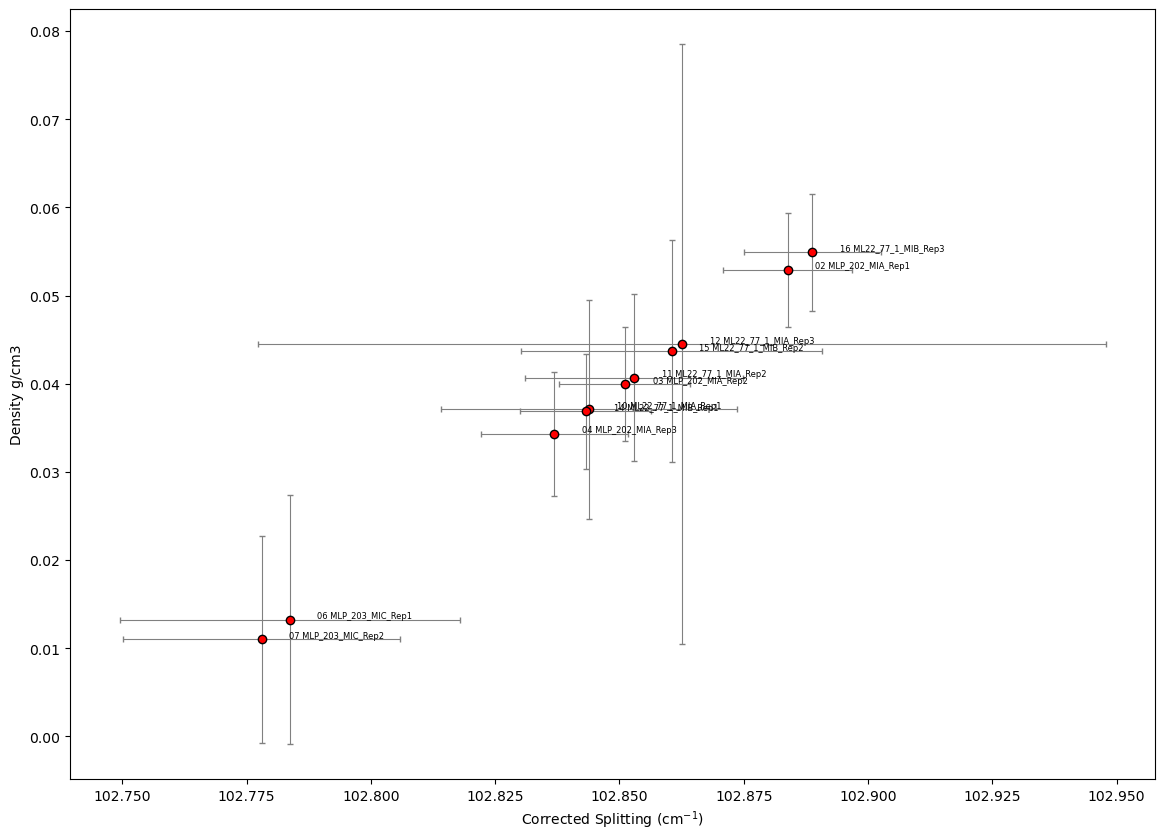

In [20]:
## This lets you read the labels
fig, (ax1) = plt.subplots(1, 1, figsize=(14,10))
df=df.loc[df['Density g/cm3']>0]
ax1.errorbar(df['Corrected_Splitting'], df['Density g/cm3'],
xerr=df['Corrected_Splitting_σ'], yerr=df['σ Density g/cm3'],
fmt='o', ecolor='grey', elinewidth=0.8, mfc='red', ms=6, mec='k', capsize=2)
for i, filename in enumerate(df['filename']):
    print(filename)
    ax1.annotate(filename, (df['Corrected_Splitting'].iloc[i], df['Density g/cm3'].iloc[i]), xytext=(20,1),  fontsize=6, textcoords='offset points')

ax1.set_xlabel('Corrected Splitting (cm$^{-1}$)')
ax1.set_ylabel('Density g/cm3')

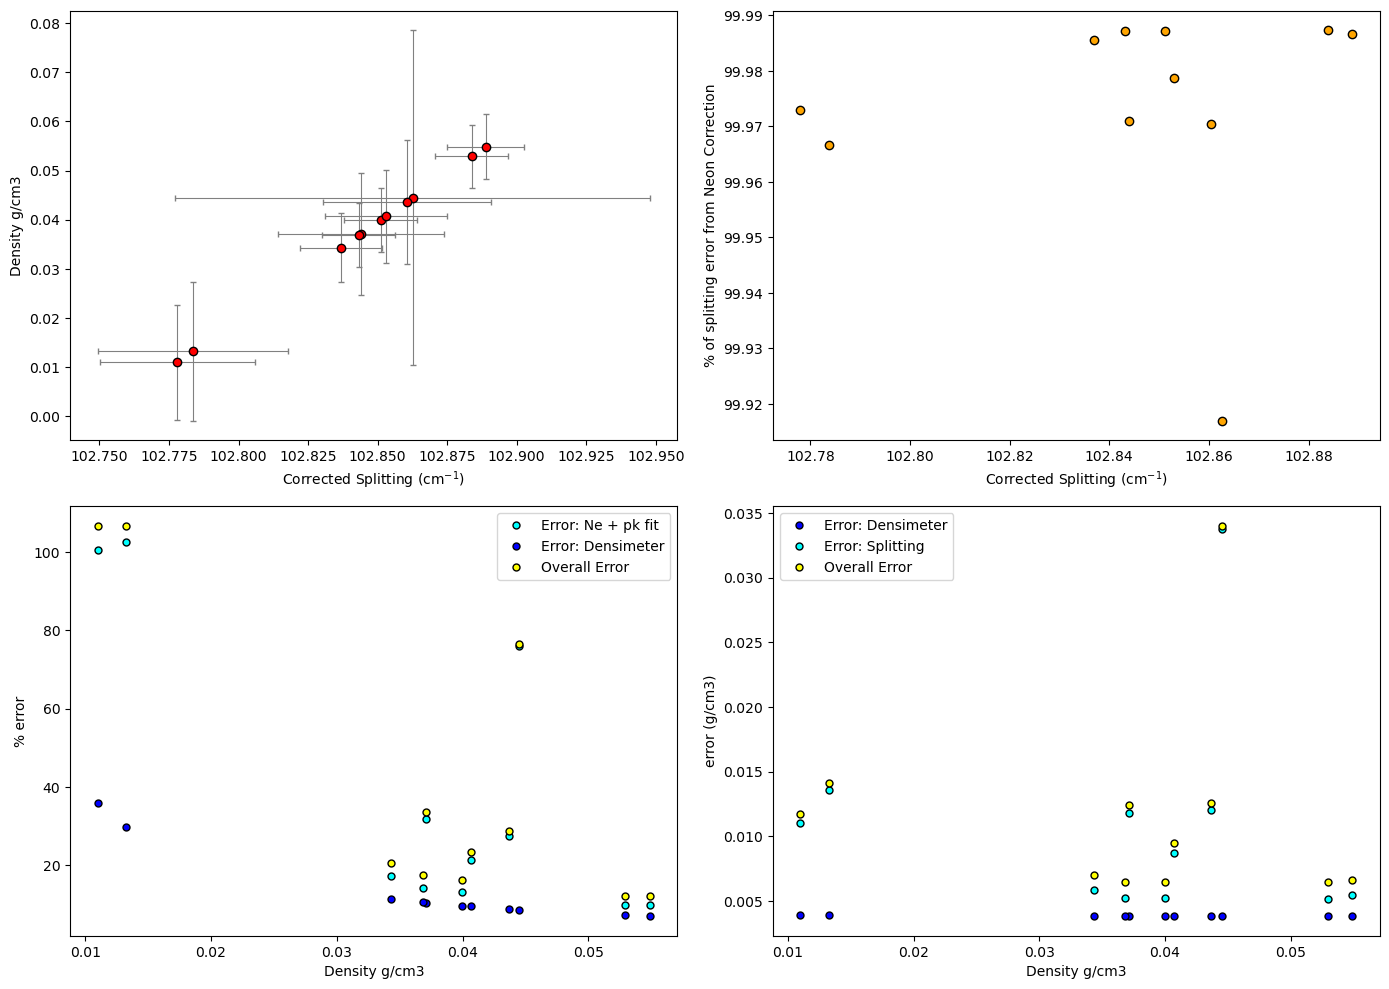

In [17]:

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(14,10))
df=df.loc[df['Density g/cm3']>0]
ax1.errorbar(df['Corrected_Splitting'], df['Density g/cm3'],
xerr=df['Corrected_Splitting_σ'], yerr=df['σ Density g/cm3'],
fmt='o', ecolor='grey', elinewidth=0.8, mfc='red', ms=6, mec='k', capsize=2)

ax1.set_xlabel('Corrected Splitting (cm$^{-1}$)')
ax1.set_ylabel('Density g/cm3')

ax2.plot(df['Corrected_Splitting'], 
100*df['Corrected_Splitting_σ_Ne']/(df['Corrected_Splitting_σ_Ne']+df['Corrected_Splitting_σ_peak_fit']),
 'ok', mfc='orange')
ax2.set_ylabel('% of splitting error from Neon Correction')
ax2.set_xlabel('Corrected Splitting (cm$^{-1}$)')
ax3.plot(df['Density g/cm3'], 100*df['σ Density g/cm3 (from Ne+peakfit)']/df['Density g/cm3'], 
'ok', mfc='cyan', ms=5, label='Error: Ne + pk fit')


ax3.plot(df['Density g/cm3'], 100*df['σ Density g/cm3 (from densimeter)']/df['Density g/cm3'], 
'ok', mfc='blue', ms=5, label='Error: Densimeter')

ax3.plot(df['Density g/cm3'], 100*df['σ Density g/cm3']/df['Density g/cm3'], 
'ok', mfc='yellow', ms=5, label='Overall Error')
ax3.set_ylabel('% error')
ax3.set_xlabel('Density g/cm3')
ax3.legend()

ax4.plot(df['Density g/cm3'], df['σ Density g/cm3 (from densimeter)'], 
'ok', mfc='blue', ms=5, label='Error: Densimeter')
ax4.plot(df['Density g/cm3'], df['σ Density g/cm3 (from Ne+peakfit)'], 
'ok', mfc='cyan', ms=5, label='Error: Splitting')
ax4.plot(df['Density g/cm3'], df['σ Density g/cm3'], 
'ok', mfc='yellow', ms=5, label='Overall Error')
ax4.set_ylabel('error (g/cm3)')
ax4.set_xlabel('Density g/cm3')
ax4.legend()

fig.tight_layout()

### This plays a sound when the notebook is done if you have a tendency to procrastinate

In [18]:
# !pip install winotify

from winotify import Notification, audio

toast= Notification(app_id="VSCode",title="Notebook completed",
                    msg="Step3b_Secondary_Peaks is done!",
                    duration="short")
toast.set_audio(audio.Mail,loop=False)
toast.show()